## Problem Definition: Causal Graph - ok

<img src="graph/causalGraph_v0820.png" width = "800">

## Step0. Package/Variable Setting - ok

In [41]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from patsy import dmatrices
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, Normalizer
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

##  Step1. Estimation of Propensity Score - ok

### 1-1. Data Processing

In [3]:
trn_df = pd.read_csv('data/MY_shopProfiling+Effects.csv', sep = ',')
tst_df = pd.read_csv('data/ID_shopProfiling.csv', sep = ',')

In [4]:
print(trn_df.shape, tst_df.shape)
trn_df.head(2)

(35588, 13) (128285, 11)


,shopid,seller_type,rating_star,display_response_rate,sku,camp_flag,main_category,p30_gmv,p30_order_cnt,follower_count,Decorated,Clicks_pre_User_Before,Clicks_pre_User_After
0,65408,NS,4.90,89,745,N,Muslim Fashion,3202.70,51,264.0,0,0.0,2.5
1,439807,NS,4.17,65,9,N,Groceries & Pets,329.04,6,101.0,0,0.0,0.0


In [5]:
# Check the null values
pd.DataFrame(data = [trn_df.isnull().sum(), tst_df.isnull().sum()], index=['trn_df','tst_df']).T

,trn_df,tst_df
shopid,0.0,0.0
seller_type,0.0,0.0
rating_star,0.0,0.0
display_response_rate,0.0,0.0
sku,0.0,0.0
camp_flag,0.0,0.0
main_category,0.0,0.0
p30_gmv,0.0,0.0
p30_order_cnt,0.0,0.0
follower_count,38.0,0.0


In [6]:
trn_df.follower_count.fillna(value = 0, inplace = True)

In [7]:
# Check
# pd.DataFrame(data = [trn_df.isnull().sum(), tst_df.isnull().sum()], index=['trn_df','tst_df']).T

In [8]:
trn_df.dtypes

shopid                      int64
seller_type                object
rating_star               float64
display_response_rate       int64
sku                         int64
camp_flag                  object
main_category              object
p30_gmv                   float64
p30_order_cnt               int64
follower_count            float64
Decorated                   int64
Clicks_pre_User_Before    float64
Clicks_pre_User_After     float64
dtype: object

In [9]:
# shop_profile.columns.values
num_cols = [n for n in trn_df.columns if is_numeric_dtype(trn_df[n])]
str_cols = [n for n in trn_df.columns if is_string_dtype(trn_df[n])]

# Drop main category due to difference of categories between MY and ID
drop_cols = ['shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After', 'main_category']
y_cols = ['Decorated']

In [10]:
trn_df.head(2)

,shopid,seller_type,rating_star,display_response_rate,sku,camp_flag,main_category,p30_gmv,p30_order_cnt,follower_count,Decorated,Clicks_pre_User_Before,Clicks_pre_User_After
0,65408,NS,4.90,89,745,N,Muslim Fashion,3202.70,51,264.0,0,0.0,2.5
1,439807,NS,4.17,65,9,N,Groceries & Pets,329.04,6,101.0,0,0.0,0.0


In [12]:
# Standardize the numeric variables
map_f = [([n],StandardScaler()) for n in trn_df.drop(columns = str_cols + y_cols + drop_cols).columns]
# map_f
mapper = DataFrameMapper(map_f).fit(trn_df)
trn_df[mapper.transformed_names_] = mapper.transform(trn_df)

In [13]:
trn_df.head(2)

,shopid,seller_type,rating_star,display_response_rate,sku,camp_flag,main_category,p30_gmv,p30_order_cnt,follower_count,Decorated,Clicks_pre_User_Before,Clicks_pre_User_After
0,65408,NS,0.412848,0.340051,0.301299,N,Muslim Fashion,-0.148874,-0.162638,-0.269229,0,0.0,2.5
1,439807,NS,-4.337566,-1.812548,-0.403096,N,Groceries & Pets,-0.244146,-0.261135,-0.315220,0,0.0,0.0


Concept of StandardScaler: After transformed, the average of features is 0 and std is 1. (Normal Distribution)

In [14]:
# Transform the category variables to dummy variables
print('drop the following columns:', drop_cols)
for_model_df = pd.get_dummies(trn_df.drop(columns = drop_cols))

drop the following columns: ['shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After', 'main_category']


In [15]:
print(for_model_df.shape)
for_model_df.head(2)

(35588, 12)


,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.412848,0.340051,0.301299,-0.148874,-0.162638,-0.269229,0,1,0,0,1,0
1,-4.337566,-1.812548,-0.403096,-0.244146,-0.261135,-0.315220,0,1,0,0,1,0


### 1-2. Modeling

In [16]:
X, y = for_model_df.drop(columns = y_cols), for_model_df[y_cols]

#### 1-2-1. Logistic Regression

In [17]:
lor = linear_model.LogisticRegression()
lor.fit(X, y)

/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
lor.predict_proba(X)[:,1]

array([0.01685413, 0.00576935, 0.01962342, ..., 0.01799453, 0.01419868,
       0.01023979])

In [19]:
print(lor.intercept_)
pd.DataFrame(data = [X.columns.values, lor.coef_[0]]).T

[0.21312768]


,0,1
0,rating_star,0.117954
1,display_response_rate,0.313364
2,sku,-0.167141
3,p30_gmv,-0.00558245
4,p30_order_cnt,-0.363279
5,follower_count,0.0525291
6,seller_type_NS,0.222823
7,seller_type_OS,0.02202
8,seller_type_PS,-0.0317153
9,camp_flag_N,-4.65278


In [27]:
# AUC
roc_auc_score(y, lor.predict_proba(X)[:,1])

0.8354485653386354

#### 1-2-2. Logit

<img src="graph/logit.svg" width = "500">

In [22]:
for_model_df.head(1)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.412848,0.340051,0.301299,-0.148874,-0.162638,-0.269229,0,1,0,0,1,0


In [23]:
# Create the Intercept for logit
_y, _X = dmatrices('Decorated ~ rating_star + display_response_rate + sku + p30_gmv + p30_order_cnt + follower_count + seller_type_NS + seller_type_OS + seller_type_PS + camp_flag_N + camp_flag_Y', 
                 for_model_df, return_type = 'dataframe')

In [24]:
logit = sm.Logit(_y,_X).fit(method='bfgs')

         Current function value: 0.076492
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/ericwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ericwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [25]:
logit.params

Intercept                0.018557
rating_star              0.141737
display_response_rate    0.314615
sku                     -0.196572
p30_gmv                 -0.131135
p30_order_cnt           -0.124562
follower_count           0.034715
seller_type_NS           0.456319
seller_type_OS          -0.043288
seller_type_PS          -0.394474
camp_flag_N             -4.647814
camp_flag_Y              4.666372
dtype: float64

In [28]:
roc_auc_score(_y, logit.predict(_X))

0.8321786774786808

### 1-3. Model assessment

#### 1-3-1. Data Processing for tst_df

In [30]:
# shop_profile.columns.values
num_cols = [n for n in tst_df.columns if is_numeric_dtype(tst_df[n])]
str_cols = [n for n in tst_df.columns if is_string_dtype(tst_df[n])]
# Drop main category due to difference of categories between MY and ID
drop_cols = ['shopid','main_category']
y_cols = ['Decorated']


# Standardize the numeric variables
map_f = [([n],StandardScaler()) for n in tst_df.drop(columns = str_cols + y_cols + drop_cols).columns]
# map_f
mapper = DataFrameMapper(map_f).fit(tst_df)
tst_df[mapper.transformed_names_] = mapper.transform(tst_df)


# Transform the category variables to dummy variables
print('drop the following columns:', drop_cols)
for_model_tst_df = pd.get_dummies(tst_df.drop(columns = drop_cols))

drop the following columns: ['shopid', 'main_category']


In [31]:
print(for_model_tst_df.shape)
for_model_tst_df.head(2)

(128285, 12)


,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.157007,0.048215,-0.340031,-0.147584,-0.162868,-0.183219,0,1,0,0,1,0
1,-2.740833,0.149147,-0.318322,-0.147676,-0.165574,-0.123038,0,1,0,0,1,0


#### 1-3-2. Assess the different models

In [32]:
tst_X, tst_y = for_model_tst_df.drop(columns = y_cols), for_model_tst_df[y_cols]

In [33]:
model1_roc = roc_auc_score(tst_y, lor.predict_proba(tst_X)[:,1])
model1_roc

0.8735959762433259

In [34]:
# Create the Intercept for logit
tst_y, tst_X = dmatrices('Decorated ~ rating_star + display_response_rate + sku + p30_gmv + p30_order_cnt + follower_count + seller_type_NS + seller_type_OS + seller_type_PS + camp_flag_N + camp_flag_Y', 
                         for_model_tst_df, return_type = 'dataframe')

In [35]:
model2_roc = roc_auc_score(tst_y, logit.predict(tst_X))
model2_roc

0.8777105818181667

### 1-4. Observe the propensity

In [37]:
for_model_df.head(2)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y
0,0.412848,0.340051,0.301299,-0.148874,-0.162638,-0.269229,0,1,0,0,1,0
1,-4.337566,-1.812548,-0.403096,-0.244146,-0.261135,-0.315220,0,1,0,0,1,0


In [51]:
plot_df = for_model_df.copy()
plot_df['logit_score'] = logit.predict(_X)
# plot_df['logistic_score'] = lor.predict_proba(X)[:,1]

Text(0.5, 0.98, 'Probability of decorating the shop')

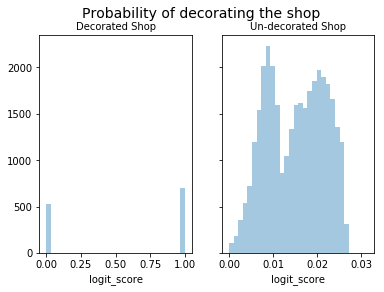

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
sns.distplot(plot_df[plot_df.Decorated == 1]['logit_score'], bins= 30, kde=False, hist=True, ax= ax1)
sns.distplot(plot_df[plot_df.Decorated == 0]['logit_score'], bins= 30, kde=False, hist=True, ax= ax2)

ax1.set_title("Decorated Shop", fontsize=10)
ax2.set_title("Un-decorated Shop", fontsize=10)
fig.suptitle("Probability of decorating the shop", fontsize=14)

## Step2. Choose Matching algorithm

### 2-1. Data Processing

In [65]:
# get the id and treatment effect
mth_df = pd.concat([plot_df.copy(), trn_df[['shopid', 'Clicks_pre_User_Before', 'Clicks_pre_User_After']]], axis = 1)
mth_df.shape

(35588, 16)

In [70]:
mth_df.tail(2)

,rating_star,display_response_rate,sku,p30_gmv,p30_order_cnt,follower_count,Decorated,seller_type_NS,seller_type_OS,seller_type_PS,camp_flag_N,camp_flag_Y,logit_score,shopid,Clicks_pre_User_Before,Clicks_pre_User_After
35586,-2.190118,0.519434,0.041936,-0.243186,-0.263324,-0.341178,0,1,0,0,1,0,0.013717,149256535,0.000000,2.2500
35587,0.933442,-1.812548,-0.395439,-0.164037,-0.149505,-0.338638,0,1,0,0,1,0,0.010935,150994626,1.434783,2.1875


In [72]:
treated = mth_df.loc[mth_df['Decorated'] == 1]
control = mth_df.loc[mth_df['Decorated'] == 0]

In [75]:
print(mth_df.shape, '=' ,treated.shape, control.shape)

(35588, 16) = (1242, 16) (34346, 16)


Could look the imbalance of covariance between treatment group and control group by standardised bias first(as Type4-1)

###  2-2. Modeling_un

#### 2-2-1. 1-N Matching

In [24]:
control_neighbors = (
    NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    .fit(control['propensity_score'].values.reshape(-1, 1))
)
distances, indices = control_neighbors.kneighbors(treated['propensity_score'].values.reshape(-1, 1))

In [25]:
len(indices)

1242

In [26]:
indices
# Question: How to conduct the replacement sampling?

array([[26883],
       [29573],
       [19843],
       ...,
       [31253],
       [31253],
       [31253]])

In [43]:
match_control = control.iloc[indices[:, 0]]

In [47]:
# match_control.drop_duplicates()

#### 2-2-2. Caliper Matching

## Step3. Check overlap and common support

## Step4. Assessing the Matching Quality

### Type4-1. Standardised Bias / Standardized DIfferences

\begin{align}
smd = \frac{\bar{X}_t - \bar{X}_c}{\sqrt{(s^2_t + s^2_c) / 2}}
\end{align}

**Pros:** Doesn't depend on sample size (compared with p-values)<br/>
**Rules of thunb**:<br/>
1.Coursera Version<br/>
- Smaller than $0.1$: Adequate balance; For a randomized trial, the smd between all of the covariates should typically fall into this bucket.
- $0.1$ - $0.2$: Not necessarily balanced, but small enough that people are usually not too worried about them.
- Greater than $0.2$: Values that are greater than this threshold are considered seriously imbalanced.

2.Paper Version<br/>
- A bias reduction below 3% or 5% is seen as sufficient

In [34]:
def assess_balance(trt_df, ctl_df, covariates):
#     trt_df = trt
#     ctl_df = ctl
    t_stat = trt_df[covariates].describe().loc['mean':'std', :].T
    c_stat = ctl_df[covariates].describe().loc['mean':'std', :].T
    assess_df = pd.concat([t_stat.add_prefix('treated_'), c_stat.add_prefix('control_')], axis = 1)
    assess_df['smd'] = abs((assess_df.treated_mean - assess_df.control_mean) / 
                       np.sqrt((assess_df.control_std**2+assess_df.treated_std**2)/2))
    
    return assess_df

### Type4-2. Pseudo-R^2

## Step5. Calculation of Treatment Effects

## Step6. Sensitivity Analysis